In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch

from dotenv import load_dotenv, find_dotenv
from pathlib import Path

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
project_dir = Path(dotenv_path).parent

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

# EffNet test

Following mostly https://pytorch.org/hub/nvidia_deeplearningexamples_efficientnet/

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [5]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

efficientnet.eval().to(device)

Using cache found in /home/ctc_das/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/ctc_das/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b4_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b4_210412.pth" to /home/ctc_das/.cache/torch/hub/checkpoints/nvidia_efficientnet-b4_210412.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

Using cache found in /home/ctc_das/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=48, out_features=12, bias=True)
          (expand): Linear(in_features=12, out_features=48, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
    

In [61]:
uris = ['http://images.cocodataset.org/test-stuff2017/000000024309.jpg',]

batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


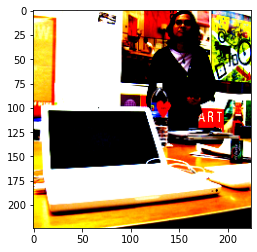

In [34]:
plt.imshow(batch[0].permute(1, 2, 0).cpu())
plt.show()

In [17]:
with torch.no_grad():
    output = efficientnet(batch)
    softm = torch.nn.functional.softmax(output, dim=1)
    
results = utils.pick_n_best(predictions=softm, n=5)
results

sample 0: [('laptop, laptop computer', '49.9%'), ('notebook, notebook computer', '36.2%'), ('desk', '3.7%'), ('mouse, computer mouse', '0.5%'), ('space bar', '0.5%')]


[[('laptop, laptop computer', '49.9%'),
  ('notebook, notebook computer', '36.2%'),
  ('desk', '3.7%'),
  ('mouse, computer mouse', '0.5%'),
  ('space bar', '0.5%')]]

# EfficientNet in our task

In [6]:
import torch.nn as nn

class PretrainedNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Sequential(
            nn.Conv2d(2, 3, 3, 1),  # adapt our 2-channel images to effnet 3 channels
            nn.BatchNorm2d(3),
        )

        self.model = efficientnet
        self.model.classifier.fc = nn.Sequential(
            nn.Linear(1792, 40),
            nn.ReLU(),
            nn.Linear(40, 1),
        )

    def forward(self, x):
        x = self.input(x)
        x = self.model(x)

        return x

net = PretrainedNet()
net

PretrainedNet(
  (input): Sequential(
    (0): Conv2d(2, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model): EfficientNet(
    (stem): Sequential(
      (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (activation): SiLU(inplace=True)
    )
    (layers): Sequential(
      (0): Sequential(
        (block0): MBConvBlock(
          (depsep): Sequential(
            (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (se): SequentialSqueezeAndExcitation(
            (squeeze): Linear(in_features=48, out_features=12, bias=True)
           

In [7]:
with h5py.File(str(project_dir/'data/interim/renders.hdf5'), "r") as h:
    i = np.random.choice(np.arange(h['train'].shape[0]))
    j = np.random.choice(np.arange(h['train'].shape[1]))
    
    sample = h['train'][i,j]

batch = torch.from_numpy(sample).unsqueeze(0)
batch = batch.type(torch.FloatTensor)  # so it agrees with weights dtype
batch = batch.to(device)
batch.shape

torch.Size([1, 2, 512, 512])

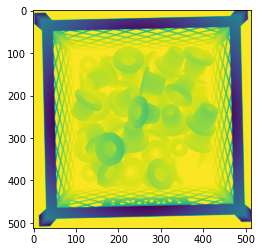

In [8]:
plt.imshow(batch[0,0].cpu())
plt.show()

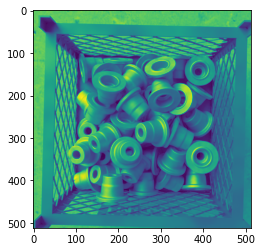

In [31]:
plt.imshow(batch[0,1].cpu())
plt.show()

In [13]:
net.to(device)
with torch.no_grad():
    batch.to(device)
    output = net(batch)

output.item()

0.11150414496660233